In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
def plot_images(imgs, names=None, axs=None, show=True, nrows=None, ncols=None, figsize=(30, 20)):
    from math import ceil
    if nrows is None and ncols is None:
        nrows = 1
        ncols = len(imgs)
    elif nrows is None:
        nrows = ceil(len(imgs) / ncols)
    elif ncols is None:
        ncols = ceil(len(imgs) / nrows)
    
    if axs is None:
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    if nrows == 1 and ncols == 1:
        img = imgs[0]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        axs.imshow(img, cmap=cmap)
        axs.set_axis_off()
        if names and len(names) > 0:
            axs.set_title(names[0], fontsize=15)
    elif nrows == 1 or ncols == 1:
        for j, ax in enumerate(axs):
            img = imgs[j]
            cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
            ax.imshow(img, cmap=cmap)
            ax.set_axis_off()
            if names and j < len(names):
                ax.set_title(names[j], fontsize=15)
    else:
        for j, ax in enumerate(axs):
            for k, sub_ax in enumerate(ax):
                image_id = j * ncols + k
                sub_ax.set_axis_off()
                if image_id < len(imgs):
                    img = imgs[image_id]
                    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
                    sub_ax.imshow(img, cmap=cmap)
                    if names and image_id < len(names):
                        sub_ax.set_title(names[image_id], fontsize=15)
    if show:
        plt.show()

In [26]:
from torchvision.transforms import ToTensor, Normalize, Compose

In [28]:
transfomatioms = Compose([ToTensor(), Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [29]:
dataset_train = datasets.CIFAR10('data', download=True, transform=transfomatioms)
dataset_valid = datasets.CIFAR10('data', download=True, transform=transfomatioms, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [36]:
class SimpleNet(nn.Module):
    def __init__(self, num_classes=10, in_channels=3):
        super().__init__()
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.act2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.act4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.act5 = nn.ReLU()
        
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        
        x = self.conv4(x)
        x = self.act4(x)
        
        x = self.conv5(x)  #        [batch_size,    num_channels, height, width]
        x = self.act5(x)  # x.shape = [1,             128,         4,       4]
        
        x = x.mean(dim=(2, 3))
        x = self.fc(x)
        return x

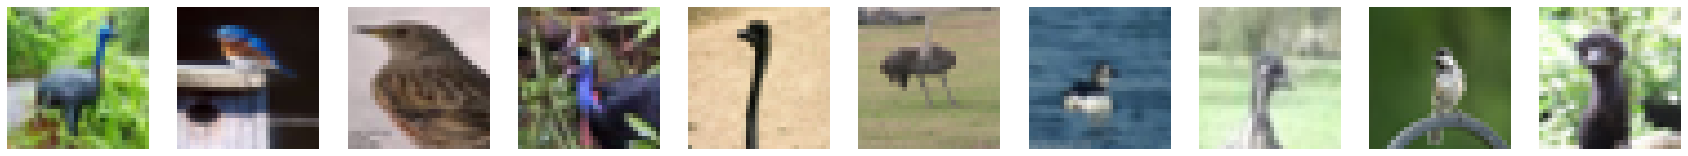

In [23]:
plot_images(dataset.data[dataset.targets == 2][:10])

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
train_dataloader = DataLoader(dataset_train, batch_size=64, num_workers=8, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=64, num_workers=8, shuffle=False)

model = SimpleNet(num_classes=10, in_channels=3).train().to(device)
sgd_optimizer = torch.optim.SGD(model.parameters(), 0.05, momentum=0.9, weight_decay=0.0005)

In [38]:
loss_f = nn.CrossEntropyLoss()

In [40]:
from tqdm import tqdm

In [59]:
num_epochs = 10
num_correct = 0
n = 0

for epoch_id in range(num_epochs):
    for batch_id, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_predicted = model(x)
        
        loss = loss_f(y_predicted, y)
        loss.backward()
        sgd_optimizer.step()
        sgd_optimizer.zero_grad()
        
        with torch.no_grad():
            num_correct += (y_predicted.argmax(1) == y).sum()
            n += y_predicted.shape[0]
    
    print(float(num_correct/n))
    num_correct = 0
    n = 0

100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:05<00:00, 141.94it/s]


0.5989199876785278


100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:05<00:00, 140.49it/s]


0.6442999839782715


100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:05<00:00, 134.18it/s]


0.679419994354248


100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:05<00:00, 135.91it/s]


0.7092399597167969


100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:05<00:00, 136.69it/s]


0.7317799925804138


100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:05<00:00, 134.67it/s]


0.748259961605072


100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:05<00:00, 135.98it/s]


0.7598599791526794


100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:05<00:00, 131.65it/s]


0.7760399580001831


100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:05<00:00, 135.28it/s]


0.7856599688529968


100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:05<00:00, 134.89it/s]

0.7935799956321716
